# Sparse inverse covariance estimation

- GraphicalLasso 추정기를 사용하여 적은 수의 샘플로부터 covariance와 희소한 precision를 학습 
#
- 확률적 모델을 추정하기 위해서는 inverse covariance 행렬인 정확도 행렬을 추정하는 것이 중요
- 가우시안 모델은 정확도 행렬로 매개변수화 된다.
#
- 희소한 inverse covariance 행렬을 가진 모델에서 데이터를 샘플링한
- 데이터가 상관관계가 없도록(정확도 행렬의 가장 큰 계수를 제한함)하고, 복원할 수 없는 작은 계수가 없도록 함
- 적은 수의 관측치로는 상관관계 행렬을 복원하기 귑기 때문에 시계열을 스케일링
- 이 예에서는 관측치들이 상관관계가 있고, empirical covariance 행렬은 조건이 안좋고, 그 결과로 inverse covariance 행렬도 실제 정확도와는 아주 멀리 떨어져 있다.
#
- Ledoit-Wolf 추정기와 같이 l2 축소를 사용하는 경우 샘플 수가 적기 때문에 축소
- Ledoit-Wolf 정확도는 실제 정확도와 가깝지만, 비대각 구조는 손실
#
- l1 패널티가 있는 추정기는 이러한 비대각 구조의 일부를 복원할 수 있다.
- 정확한 희소 패턴을 복원할 수는 없지만, l1 추정치의 가장 큰 비대각 계수는 실제 비대각 계수와 일치
- l1 정확도 추정치의 계수는 0에 편향되어 있다.
#
- GraphicalLasso의 알파 매개변수는 GraphicalLassoCV의 내부 교차 검증을 통해 모델의 희소성을 설정


## Generate the data

In [1]:
import numpy as np
from scipy import linalg

from sklearn.datasets import make_sparse_spd_matrix

n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

## Estimate the covariance

In [2]:
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf

emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

## Plot the results

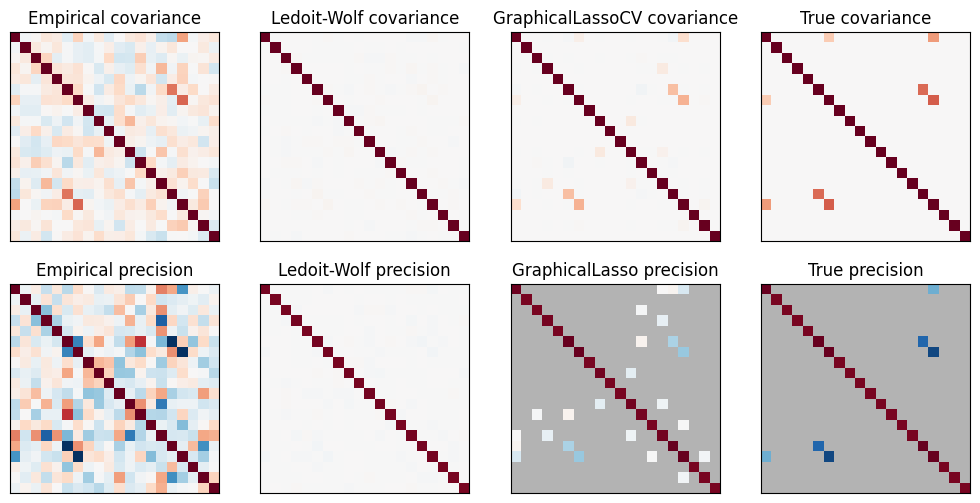

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# covariances 그리기
covs = [
    ("Empirical", emp_cov),
    ("Ledoit-Wolf", lw_cov_),
    ("GraphicalLassoCV", cov_),
    ("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)


# precisions 그리기 
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("Ledoit-Wolf", lw_prec_),
    ("GraphicalLasso", prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")

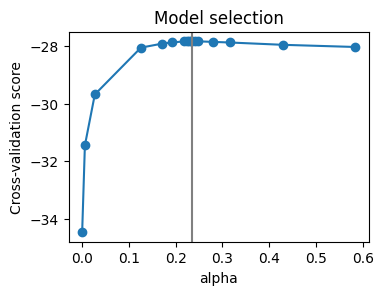

In [4]:
# model selection metric 그리기 
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()